In [62]:
from __future__ import (absolute_import, division, print_function, unicode_literals)
import random
import numpy as np
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

#from mltools.dataManager import DataManager
from mltools.baseLearner import BaseLearner

%matplotlib inline

In [56]:
class DataManager:
    MISSING = float("infinity")

    def __init__(self, arff=None):
        """
        If matrix is provided, all parameters must be provided, and the new matrix will be
        initialized with the specified portion of the provided matrix.
        """
        if arff:
            self.load_arff(arff)
        else:
            pass

    def init_from(self, matrix, row_start, col_start, row_count, col_count):
        """Initialize the matrix with a portion of another matrix"""
        self.data = [matrix.data[row][col_start:col_start+col_count] for row in range(row_start, row_start+row_count)]
        self.attr_names = matrix.attr_names[col_start:col_start+col_count]
        self.str_to_enum = matrix.str_to_enum[col_start:col_start+col_count]    # array of dictionaries
        self.enum_to_str = matrix.enum_to_str[col_start:col_start+col_count]    # array of dictionaries
        return self

    def add_data(self, new_data):
        """Appends a copy of the specified portion of a matrix to this matrix"""
        self.data = np.vstack((self.data, new_data))

    def set_labels(self):
        self.labels = self.data[:,-1]
        self.data = self.data[:,:-1]

    def test_train_split(self, ratio=.8):
        self.shuffle()
        split_point = int(self.num_rows * ratio)
        x_train = self.data[:split_point,:]
        x_test = self.data[split_point:,:]
        y_train = self.labels[:split_point]
        y_test = self.labels[split_point:]
        return x_train, x_test, y_train, y_test

    def set_size(self, rows, cols):
        """Resize this matrix (and set all attributes to be continuous)"""
        self.data = [[0]*cols for row in range(rows)]
        self.attr_names = [""] * cols
        self.str_to_enum = {}
        self.enum_to_str = {}

    def load_arff(self, filename):
        """ Load data from an ARFF file """
        self.data = []
        self.attr_names = []
        self.str_to_enum = []
        self.enum_to_str = []
        reading_data = False

        rows = []           # we read data into array of rows, then convert into array of columns

        f = open(filename)
        for line in f.readlines():
            line = line.rstrip().upper()
            if len(line) > 0 and line[0] != '%':
                if not reading_data:
                    if line.startswith("@RELATION"):
                        self.dataset_name = line[9:].strip()
                    elif line.startswith("@ATTRIBUTE"):
                        attr_def = line[10:].strip()
                        if attr_def[0] == "'":
                            attr_def = attr_def[1:]
                            attr_name = attr_def[:attr_def.index("'")]
                            attr_def = attr_def[attr_def.index("'")+1:].strip()
                        else:
                            attr_name, attr_def = attr_def.split()

                        self.attr_names += [attr_name]

                        str_to_enum = {}
                        enum_to_str = {}
                        if not(attr_def == "REAL" or attr_def == "CONTINUOUS" or attr_def == "INTEGER"):
                            # attribute is discrete
                            assert attr_def[0] == '{' and attr_def[-1] == '}'
                            attr_def = attr_def[1:-1]
                            attr_vals = attr_def.split(",")
                            val_idx = 0
                            for val in attr_vals:
                                val = val.strip()
                                enum_to_str[val_idx] = val
                                str_to_enum[val] = val_idx
                                val_idx += 1

                        self.enum_to_str.append(enum_to_str)
                        self.str_to_enum.append(str_to_enum)

                    elif line.startswith("@DATA"):
                        reading_data = True

                else:
                    # reading data
                    row = []
                    val_idx = 0
                    # print("{}".format(line))
                    vals = line.split(",")
                    for val in vals:
                        val = val.strip()
                        if not val:
                            raise Exception("Missing data element in row with data '{}'".format(line))
                        else:
                            row += [float(self.MISSING if val == "?" else self.str_to_enum[val_idx].get(val, val))]

                        val_idx += 1

                    rows += [row]

        f.close()
        self.data=np.array(rows)
        self.set_labels()


    @property
    def num_rows(self):
        """Get the number of rows in the matrix"""
        return len(self.data)

    @property
    def num_cols(self):
        """Get the number of columns (or attributes) in the matrix"""
        return len(self.attr_names)

    
    def attr_name(self, col):
        """Get the name of the specified attribute"""
        return self.attr_names[col]

    def attr_value(self, attr, val):
        """
        Get the name of the specified value (attr is a column index)
        :param attr: index of the column
        :param val: index of the value in the column attribute list
        :return:
        """
        return self.enum_to_str[attr][val]

    def value_count(self, col):
        """
        Get the number of values associated with the specified attribute (or columnn)
        0=continuous, 2=binary, 3=trinary, etc.
        """
        return len(self.enum_to_str[col]) if len(self.enum_to_str) > 0 else 0

    def shuffle(self):
        """Shuffle the row order. If a buddy Matrix is provided, it will be shuffled in the same order."""
        idx = np.random.permutation(self.num_rows)
        self.data = self.data[idx]
        self.labels = self.labels[idx]

     
    def mean(self):
        return np.mean(self.data, axis=0)

    def column_mean(self, col):
        """Get the mean of the specified column"""
        a = np.ma.masked_equal(self.data[:,col], self.MISSING).compressed()
        return np.mean(a)

    def column_min(self, col):
        """Get the min value in the specified column"""
        a = np.ma.masked_equal(self.data[:,col], self.MISSING).compressed()
        return np.min(a)

    def column_max(self, col):
        """Get the max value in the specified column"""
        a = np.ma.masked_equal(self.data[:,col], self.MISSING).compressed()
        return np.max(a)

    def most_common_value(self, col):
        """Get the most common value in the specified column"""
        a = np.ma.masked_equal(self.data[:,col], self.MISSING).compressed()
        scores = np.unique(np.ravel(a))       # get ALL unique values
        testshape = list(a.shape)
        testshape[axis] = 1
        oldmostfreq = np.zeros(testshape)
        oldcounts = np.zeros(testshape)

        for score in scores:
            template = (a == score)
            counts = np.expand_dims(np.sum(template, axis),axis)
            mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
            oldcounts = np.maximum(counts, oldcounts)
            oldmostfreq = mostfrequent
        
        return mostfrequent

    def normalize(self):
        """Normalize each column of continuous values"""
        for i in range(self.num_cols):
            if self.value_count(i) == 0:     # is continuous
                min_val = self.column_min(i)
                max_val = self.column_max(i)
                for j in range(self.num_rows):
                    v = self.data[j, i]
                    if v != self.MISSING:
                        self.data[j, i] = (v - min_val)/(max_val - min_val)
                        
    def __str__(self):
        outString = ""
        print("@RELATION {}".format(self.dataset_name))
        for i in range(len(self.attr_names)):
            print("@ATTRIBUTE {}".format(self.attr_names[i]), end="")
            if self.value_count(i) == 0:
                print(" CONTINUOUS")
            else:
                print(" {{{}}}".format(", ".join(self.enum_to_str[i].values())))

        print("@DATA")
        print(self.data)

    def __str__(self):
        outString = ""
        outString += "@RELATION {}".format(self.dataset_name)
        for i in range(len(self.attr_names)):
            outString += "@ATTRIBUTE {}\n".format(self.attr_names[i])
            if self.value_count(i) == 0:
                outString += " CONTINUOUS\n"
            else:
                outString += " {{{}}}\n".format(", ".join(self.enum_to_str[i].values()))

        outString += "@DATA\n"
        outString += str(self.data)
        return outString
        


In [65]:
d = DataManager(arff='./datasets/seperable.arff')
print(d)

@RELATION SEPERABLE@ATTRIBUTE X
 CONTINUOUS
@ATTRIBUTE Y
 CONTINUOUS
@ATTRIBUTE CLASS
 {1, 0}
@DATA
[[ 0.25  0.25]
 [ 0.1   0.1 ]
 [ 0.5   0.25]
 [ 0.2   0.75]
 [-0.25 -0.25]
 [-0.1  -0.1 ]
 [-0.5  -0.25]
 [-0.2  -0.75]]


In [124]:
data = DataManager(arff='./mltools/data/voting.arff')
x_train, x_test, y_train, y_test = data.test_train_split()

In [125]:
class Perceptron(BaseLearner):
    
    def train(self, x_train, y_train, lr=.001, thresh=0):
        # Add Bias
        x_train = np.hstack((np.ones((x_train.shape[0],1)), x_train))
        n, d = x_train.shape
        
        # Initialize Weights
        self.w = np.random.randn(d)
        
        for j in range(1,20):
            for i in range(n):
                predicted = np.dot(self.w, x_train[i])
                predicted = 0 if predicted < thresh else 1
                self.w = self.w - (lr * (y_train[i] - predicted) * x_train[i])
            
    
    def predict(self, x_test, thresh=0):
        x_test = np.hstack((np.ones((x_test.shape[0], 1)), x_test))
        probs = np.dot(x_test, self.w)
        probs[probs > thresh] = 1
        probs[probs <= thresh] = 0
        return probs

In [126]:
model = Perceptron()
model.train(x_train, y_train)
y_hat = model.predict(x_train)

In [127]:
accuracy_score(y_hat, y_train)

0.39673913043478259

1.  (40%) Correctly implement the perceptron learning algorithm.  For this and the following projects, you should integrate the learning algorithm with the tool kit or with your variation of the tool kit if you do your own.  Before implementing your perceptron and other projects, you should review requirements for the project so that you implement it in a way that will support them all. Note that for this and the other labs it is not always easy to tell if you have implemented the model exactly correct, since training sets, initial parameters, etc. usually have a random aspect. However, it is easy to see when your results are inconsistent with reasonable results, and points will be reduced based on how far off your implementation appears to be.

2 (5%) Create 2 ARFF files, both with 8 instances using 2 real valued inputs (which range between -1 and 1) each with 4 instances from each class.  One should be linearly separable and the other not.


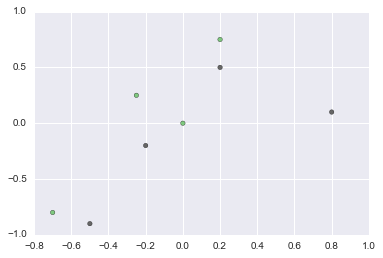

In [77]:
test = DataManager('datasets/nonseperable.arff')
plt.scatter(test.data[:,0], test.data[:,1], c=test.labels, cmap=cm.Accent)
plt.show()

3.  (10%) Train on both sets (the entire sets) with the Perceptron Rule. Try it with a couple different learning rates and discuss the effect of learning rate, including how many epochs are completed before stopping.  (For these situations learning rate should have minimal effect, unlike with the Backpropagation lab).  The basic stopping criteria for many models is to stop training when no longer making significant progress.  Most commonly, when you have gone a number of epochs (e.g. 5) with no significant improvement in accuracy (Note that the weights/accuracy do not usually change monotonically).  Describe your specific stopping criteria.  Don’t just stop the first epoch when no improvement occurs.  Use a learning rate of .1 for experiments 4-6 below.

4. (10%) Graph the instances and decision line for the two cases above (with LR=.1). For all graphs always label the axes!

5. (20%) Use the perceptron rule to learn this version of the voting task.  This particular task is an edited version of the standard voting set, where we have replaced all the “don’t know” values with the most common value for the particular attribute.  Randomly split the data into 70% training and 30% test set.  Try it five times with different random 70/30 splits.  For each split report the final training and test set accuracy and the # of epochs required.  Also report the average of these values from the 5 trials.  You should update after every instance.  Remember to shuffle the data order after each epoch.  By looking at the weights, explain what the model has learned and how the individual input features affect the result.  Which specific features are most critical for the voting task, and which are least critical?  Do one graph of the average misclassification rate vs epochs (0th – final epoch) for the training set. In our helps page is some help for doing graphs.  As a rough sanity check, typical Perceptron accuracies for the voting data set are 90%-98%.


6.  (15%) Do your own experiment with either the perceptron or delta rule.  Include in your discussion what you learned from the experiment.  Have fun and be creative!  For this lab and all the future labs make sure you do something more than just try out the model on different data sets.  One option you can do to fulfill this part is the following:

Use the perceptron rule to learn the iris task or some other task with more than two possible output values. Note that the iris data set has 3 output classes, and a perceptron node only has two possible outputs.  Two common ways to deal with this are:

a)  Create 1 perceptron for each output class.  Each perceptron has its own training set which considers its class positive and all other classes to be negative examples.  Run all three perceptrons on novel data and set the class to the label of the perceptron which outputs high.  If there is a tie, choose the perceptron with the highest net value.

b)  Create 1 perceptron for each pair of output classes, where the training set only contains examples from the 2 classes.  Run all perceptrons on novel data and set the class to the label with the most wins (votes) from the perceptrons.  In case of a tie, use the net values to decide.

You could implement one of these.  For either of these approaches you can train up the models independently or simultaneously.  For testing you just execute the novel instance on each model and combine the overall results to see which output class wins.

Note:  In order to help you debug this and other projects we have included some small examples and other hints with actual learned hypotheses so that you can compare the results of your code and help ensure that your code is working properly.  You may also discuss and compare results with classmates.